# Sistema de juego !Realiza el movimiento correcto!

## Mecanica
Realizar los movimientos indicados por el sistema, los datos seran recabados desde su celular para evaluar si estos se han realizado correctamente

In [1]:
%matplotlib widget  



Cargamos librerias necesarias

In [3]:
import websocket
import json
import numpy as np
import pandas as pd
from joblib import load
from threading import Thread, Lock
from queue import Queue
import time 

pd.set_option('future.no_silent_downcasting', True)

Cargamos el modelo y encoder

In [5]:
scaler = load('scaler.joblib')
encoder = load('encoder.joblib')
model = load('modelo_svmFis.joblib')

C:\Users\andyl\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\andyl\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\andyl\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.4.2. This might lead to breaking code or inva

### Valores constantes acordes al entrenamiento del modelo
Se definen los valores de extraccion para los datos recabados en tiempo real

In [7]:
VENTANA_MUESTRAS = 50  
SOLAPAMIENTO = 25      
buffer = pd.DataFrame(columns=[
    'timestamp', 
    'accel_x', 'accel_y', 'accel_z', 
    'gyro_x', 'gyro_y', 'gyro_z'
]).astype({
    'timestamp': 'int64',
    'accel_x': 'float64',
    'accel_y': 'float64',
    'accel_z': 'float64',
    'gyro_x': 'float64',
    'gyro_y': 'float64',
    'gyro_z': 'float64'
})
lock = Lock()  
predicciones = Queue()

In [9]:
def extraer_caracteristicas(ventana):
    return {
        
        'GyroX_mean': ventana['gyro_x'].mean(),
        'GyroX_std': ventana['gyro_x'].std(),
        'GyroX_max': ventana['gyro_x'].max(),
        'GyroX_min': ventana['gyro_x'].min(),
        
        'GyroY_mean': ventana['gyro_y'].mean(),
        'GyroY_std': ventana['gyro_y'].std(),
        'GyroY_max': ventana['gyro_y'].max(),
        'GyroY_min': ventana['gyro_y'].min(),
        
        'GyroZ_mean': ventana['gyro_z'].mean(),
        'GyroZ_std': ventana['gyro_z'].std(),
        'GyroZ_max': ventana['gyro_z'].max(),
        'GyroZ_min': ventana['gyro_z'].min(),
        
        # Acelerómetro (AccelX, AccelY, AccelZ)
        'AccelX_mean': ventana['accel_x'].mean(),
        'AccelX_std': ventana['accel_x'].std(),
        'AccelX_max': ventana['accel_x'].max(),
        'AccelX_min': ventana['accel_x'].min(),
        
        'AccelY_mean': ventana['accel_y'].mean(),
        'AccelY_std': ventana['accel_y'].std(),
        'AccelY_max': ventana['accel_y'].max(),
        'AccelY_min': ventana['accel_y'].min(),
        
        'AccelZ_mean': ventana['accel_z'].mean(),
        'AccelZ_std': ventana['accel_z'].std(),
        'AccelZ_max': ventana['accel_z'].max(),
        'AccelZ_min': ventana['accel_z'].min()
    }


# Metodo de obtencion de datos

### Se utiliza la aplicación SensorServer que genera una conexión utilizando WebSocket para el envio de sensores del celular. Esta aplicacion tiene un modo web y el siguiente script para conexion utilizando sockets en Python

Ejemplo de modo web
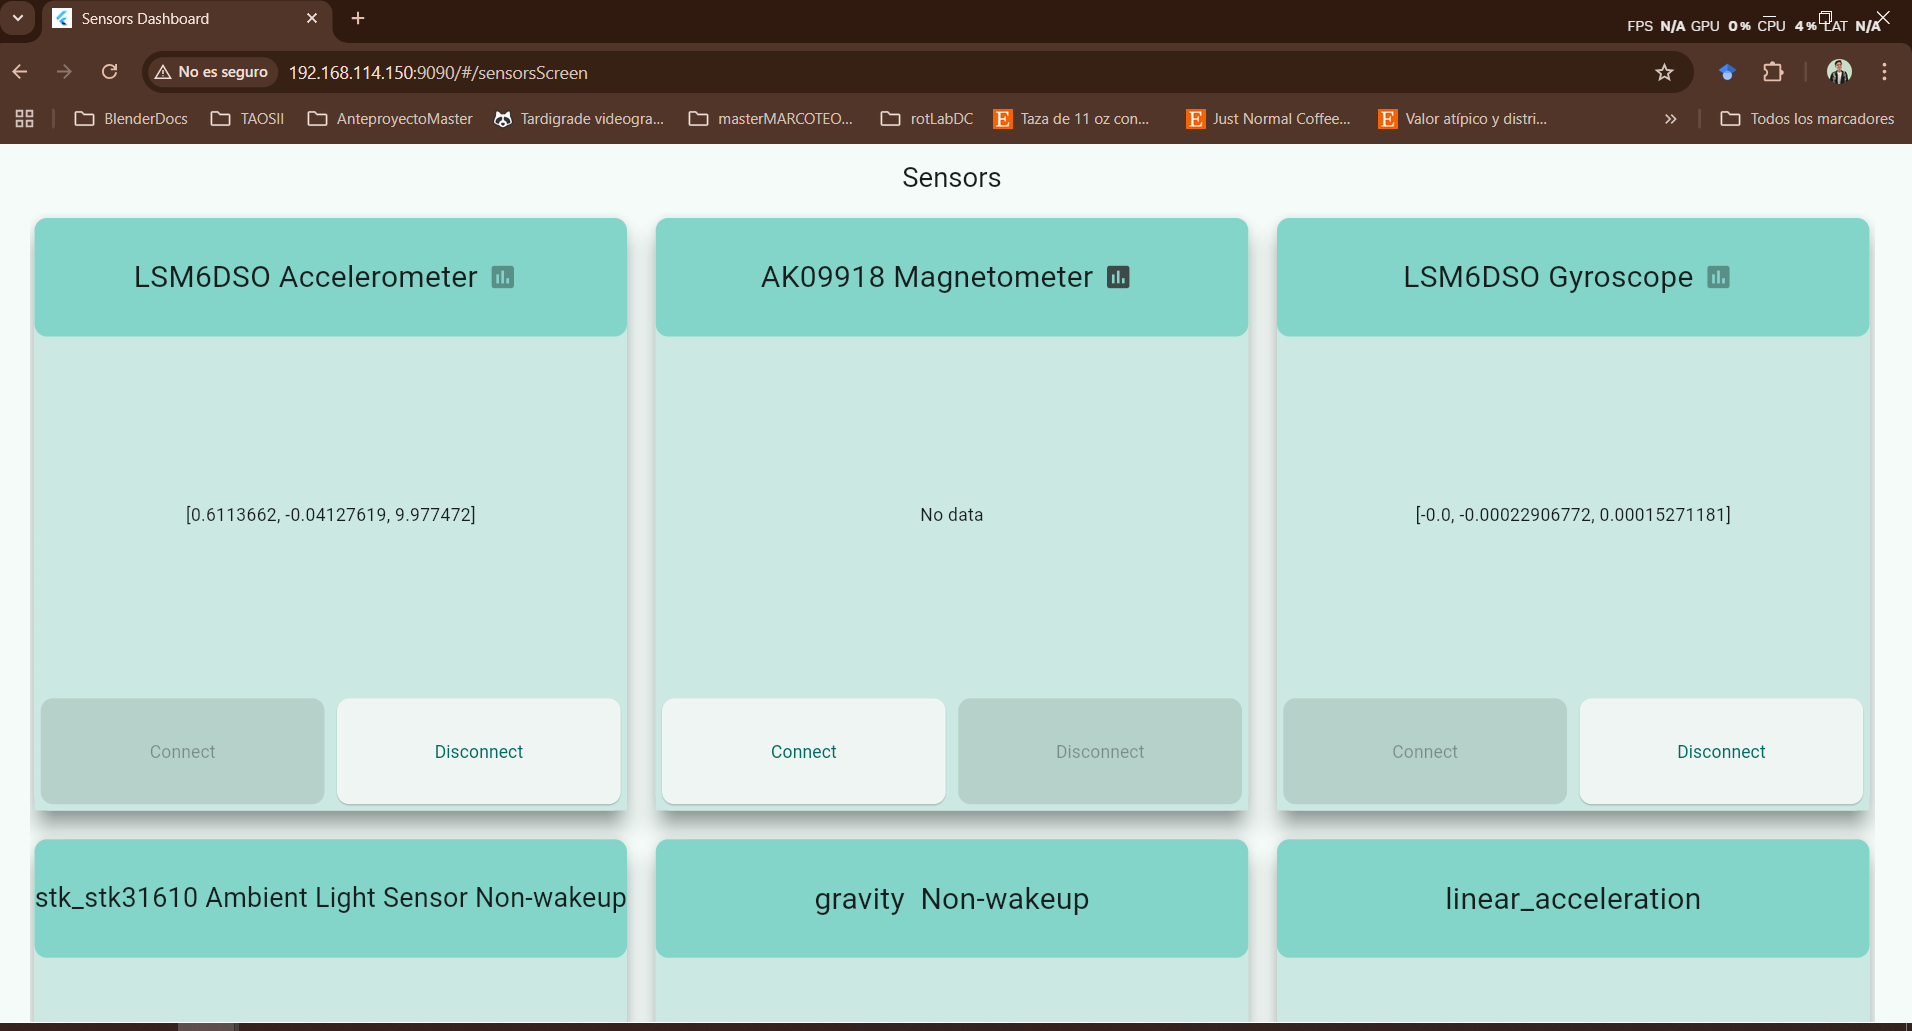

In [11]:
class SensorProcessor:
    def __init__(self):
        self.ws = websocket.WebSocketApp(
            "ws://192.168.114.150:8080/sensors/connect?types=[\"android.sensor.accelerometer\",\"android.sensor.gyroscope\"]",
            on_open=self.on_open,
            on_message=self.on_message,
            on_error=self.on_error,
            on_close=self.on_close
        )
        
    def on_message(self, ws, message):
        data = json.loads(message)
        sensor_type = data.get("type", "")
        values = data.get("values", [0.0, 0.0, 0.0]) 
        
        
       
        
        with lock:
            new_row = {"timestamp": data["timestamp"]}
            if sensor_type == "android.sensor.accelerometer":
                new_row.update({
                    "accel_x": values[0],
                    "accel_y": values[1],
                    "accel_z": values[2]
                })
            elif sensor_type == "android.sensor.gyroscope":
                new_row.update({
                    "gyro_x": values[0],
                    "gyro_y": values[1],
                    "gyro_z": values[2]
                })
            else:
                print(f"Tipo de sensor desconocido: {sensor_type}")
                return
            
            global buffer
            buffer = pd.concat([buffer, pd.DataFrame([new_row])], ignore_index=True)
            print(f"Datos recibidos - Sensor: {sensor_type} | Valores: {new_row}")
            
            if len(buffer) > 2 * VENTANA_MUESTRAS:
                buffer = buffer.iloc[-VENTANA_MUESTRAS*2:]
                
            
            if len(buffer) >= VENTANA_MUESTRAS:
                ventana = (
                    buffer.iloc[-VENTANA_MUESTRAS:]
                    .ffill()
                    .fillna(0)
                    .infer_objects(copy=False) 
                    .astype(float)  
                )
                
              
                features = {
                    
                    'GyroX_mean': ventana['gyro_x'].mean(),
                    'GyroX_std': ventana['gyro_x'].std(),
                    'GyroX_max': ventana['gyro_x'].max(),
                    'GyroX_min': ventana['gyro_x'].min(),
                    
                    'GyroY_mean': ventana['gyro_y'].mean(),
                    'GyroY_std': ventana['gyro_y'].std(),
                    'GyroY_max': ventana['gyro_y'].max(),
                    'GyroY_min': ventana['gyro_y'].min(),
                    
                    'GyroZ_mean': ventana['gyro_z'].mean(),
                    'GyroZ_std': ventana['gyro_z'].std(),
                    'GyroZ_max': ventana['gyro_z'].max(),
                    'GyroZ_min': ventana['gyro_z'].min(),
                    
                    
                    'AccelX_mean': ventana['accel_x'].mean(),
                    'AccelX_std': ventana['accel_x'].std(),
                    'AccelX_max': ventana['accel_x'].max(),
                    'AccelX_min': ventana['accel_x'].min(),
                    
                    'AccelY_mean': ventana['accel_y'].mean(),
                    'AccelY_std': ventana['accel_y'].std(),
                    'AccelY_max': ventana['accel_y'].max(),
                    'AccelY_min': ventana['accel_y'].min(),
                    
                    'AccelZ_mean': ventana['accel_z'].mean(),
                    'AccelZ_std': ventana['accel_z'].std(),
                    'AccelZ_max': ventana['accel_z'].max(),
                    'AccelZ_min': ventana['accel_z'].min()
                }
                
                # Crear DataFrame 
                features_df = pd.DataFrame([features])
                print("Características extraídas:", features)
                # Escalar y predecir
                scaled_features = scaler.transform(features_df)
                prediction = model.predict(scaled_features)[0]
                predicciones.put(encoder.inverse_transform([prediction])[0])
                print("Características escaladas:", scaled_features)
                
                buffer = buffer.iloc[SOLAPAMIENTO:].reset_index(drop=True)

    def on_error(self, ws, error):
        print("Error:", error)

    def on_close(self, ws, close_status, reason):
        print("Conexión cerrada")

    def on_open(self, ws):
        print("Conectado a sensores!")

    def start(self):
        Thread(target=self.ws.run_forever).start()

## Generamos las predicciones a los movimientos de entrada 

In [13]:
def mostrar_predicciones():
    
    try:
        while True:
            if not predicciones.empty():
                movimiento = predicciones.get()
                print(f"Movimiento detectado: {movimiento}")
            
            time.sleep(0.1)
    except KeyboardInterrupt:
        print("\nMonitor detenido.")

## Juego

La logica del juego se basa en un "SIMON DICE", donde se le indica al usuario que movimiento debe hacer, tiene un tiempo limite para realizar la mayor cantidad de movimientos

In [25]:
import time
import random
from IPython.display import clear_output


TIEMPO_JUEGO = 30  
TIEMPO_OBJETIVO = 5  
CLASES = encoder.classes_.tolist()  # ['rot_izquierda', 'rot_derecha', 'arriba', 'izquierdoArm']

# Logica para comprobar movimientos correctos y asignacion de puntos
class JuegoRehabilitacion:
    def __init__(self):
        self.puntuacion = 0
        self.tiempo_inicio = None
        self.objetivo_actual = None
        self.ultimo_objetivo_tiempo = 0
        self.ultimo_movimiento_detectado = None
        self.en_juego = False
        
    def iniciar(self):
        self.en_juego = True
        self.puntuacion = 0
        self.tiempo_inicio = time.time()
        self.actualizar_objetivo()
        print("¡Comienza el juego! Tienes 30 segundos.")
        
    def actualizar_objetivo(self):
        self.objetivo_actual = random.choice(CLASES)
        self.ultimo_objetivo_tiempo = time.time()
        
    def verificar_movimiento(self, movimiento):
        tiempo_actual = time.time()
        if tiempo_actual - self.ultimo_objetivo_tiempo > TIEMPO_OBJETIVO:
            self.actualizar_objetivo()
            
        if movimiento == self.objetivo_actual:
            if movimiento != self.ultimo_movimiento_detectado:  # Evitar puntos duplicados
                self.puntuacion += 1
                self.ultimo_movimiento_detectado = movimiento
                return True
        return False
    
    def tiempo_restante(self):
        return TIEMPO_JUEGO - (time.time() - self.tiempo_inicio)


# Interfaz 

def mostrar_interfaz(juego):
    clear_output(wait=True)
    if not juego.en_juego:
        return
    
    # Símbolos 
    flechas = {
        'rot_izquierda': '⬅️',
        'rot_derecha': '➡️',
        'arriba': '⬆️',
        'izquierdoArm': '👆'  
    }
    
    print(f"\n⏳ Tiempo restante: {max(0, int(juego.tiempo_restante()))}s")
    print(f"🎯 Movimiento requerido: {flechas[juego.objetivo_actual]} {juego.objetivo_actual}")
    print(f"🏆 Puntuación: {juego.puntuacion}")
    print("=====================================")


# Loop Principal del Juego

def jugar():
    juego = JuegoRehabilitacion()
    juego.iniciar()
    
    
    sp = SensorProcessor()
    sp.start()
    
    try:
        while juego.tiempo_restante() > 0:
            mostrar_interfaz(juego)
            
            # Verificar predicciones
            if not predicciones.empty():
                movimiento = predicciones.get()
                if juego.verificar_movimiento(movimiento):
                    print(f"✅ Correcto! +1 punto ({movimiento})")
                    
            time.sleep(0.1)
            
        print("\n⏰ ¡Tiempo terminado!")
        print(f"🔥 Puntuación final: {juego.puntuacion}")
        
    except KeyboardInterrupt:
        print("\nJuego interrumpido")
        
    finally:
        juego.en_juego = False


## Se corre en loop de juego

In [27]:
if __name__ == "__main__":
    sp = SensorProcessor()
    sp.start()
    #mostrar_predicciones()  
    jugar()


⏳ Tiempo restante: 0s
🎯 Movimiento requerido: ➡️ rot_derecha
🏆 Puntuación: 1
Datos recibidos - Sensor: android.sensor.accelerometer | Valores: {'timestamp': 764430824992533, 'accel_x': 1.3190435, 'accel_y': -9.961619, 'accel_z': 1.5568303}
Datos recibidos - Sensor: android.sensor.accelerometer | Valores: {'timestamp': 764430824992533, 'accel_x': 1.3190435, 'accel_y': -9.961619, 'accel_z': 1.5568303}

⏰ ¡Tiempo terminado!
🔥 Puntuación final: 1
